# NII Files Processing

This notebook loads the original [Liver Tumor Segmentation dataset](https://www.kaggle.com/datasets/andrewmvd/liver-tumor-segmentation), consisting of 130 CT scans saved as .NII files, applies appropriate processing to the images contained in them and saves them to Google Drive so they can be accessed at a later point and used directly.

In [ ]:
# Kaggle credentials
%env KAGGLE_USERNAME=ENTER_KAGGLE_USERNAME
%env KAGGLE_KEY=ENTER_KAGGLE_KEY

In [ ]:
# Download the dataset using the kaggle CLI tool
!kaggle datasets download andrewmvd/liver-tumor-segmentation
!kaggle datasets download andrewmvd/liver-tumor-segmentation-part-2

100% 4.83G/4.84G [00:38<00:00, 132MB/s]
100% 4.84G/4.84G [00:39<00:00, 133MB/s]
100% 10.8G/10.8G [01:30<00:00, 111MB/s] 
100% 10.8G/10.8G [01:30<00:00, 128MB/s]


In [ ]:
# Unzip the downloaded archives
!unzip -d liver-tumor-segmentation liver-tumor-segmentation.zip > /dev/null
!unzip -d liver-tumor-segmentation-part-2 liver-tumor-segmentation-part-2.zip > /dev/null

In [ ]:
# Remove the archives to save space
!rm liver-tumor-segmentation.zip
!rm liver-tumor-segmentation-part-2.zip

In [ ]:
# Display dataset size
!du -sh liv*

29G	liver-tumor-segmentation
22G	liver-tumor-segmentation-part-2


In [ ]:
# Importing required Python packages
import pandas as pd
from itertools import chain
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import types
import torch
from fastai.basics import patch, Tensor, tensor, show_image
from fastai.vision.all import TensorImageBW, IntToFloatTensor, Normalize, DataBlock, ImageBlock, MaskBlock, RandomSplitter, Resize, get_image_files
from PIL import Image
from tqdm import tqdm

In [ ]:
# Create a dataframe with all files
file_list = []
path_1 = Path('liver-tumor-segmentation')
path_2 = Path('liver-tumor-segmentation-part-2')

for dir in chain(path_1.glob('*'), path_2.glob('*')):
    for file in dir.glob('*'):
        file_list.append((dir.as_posix(), file.name)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
30,liver-tumor-segmentation/segmentations,segmentation-0.nii
32,liver-tumor-segmentation/segmentations,segmentation-1.nii
124,liver-tumor-segmentation/segmentations,segmentation-10.nii
89,liver-tumor-segmentation/segmentations,segmentation-100.nii
134,liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
219,liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii
253,liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii
226,liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii
227,liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii


In [ ]:
# Modify the dataframe by assigning the corresponding mask file to each image

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(len(file_list) // 2):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,liver-tumor-segmentation/volume_pt1,volume-0.nii,liver-tumor-segmentation/segmentations,segmentation-0.nii
1,liver-tumor-segmentation/volume_pt1,volume-1.nii,liver-tumor-segmentation/segmentations,segmentation-1.nii
2,liver-tumor-segmentation/volume_pt1,volume-10.nii,liver-tumor-segmentation/segmentations,segmentation-10.nii
3,liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,liver-tumor-segmentation/segmentations,segmentation-100.nii
4,liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii,liver-tumor-segmentation/segmentations,segmentation-95.nii
127,liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii,liver-tumor-segmentation/segmentations,segmentation-96.nii
128,liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii,liver-tumor-segmentation/segmentations,segmentation-97.nii
129,liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii,liver-tumor-segmentation/segmentations,segmentation-98.nii


In [ ]:
# Function that reads and returns the image data contained in a nii file
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    fdata   = ct_scan.get_fdata()
    array   = np.rot90(fdata)
    return array

In [ ]:
# Loading a samle file
ct_scan = nib.load(df_files.loc[0,'dirname']+"/"+df_files.loc[0,'filename'])

In [ ]:
# Printing the file dimensions
sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [ ]:
# Printing the min and max values for a sample image and mask
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


In [ ]:
# .NII images can contain a high amount of voxel values and windowing can be thought of as a means of manipulating 
# these values in order to change the apperance of the image so particular structures are highlighted. 

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(arr: Tensor, w, l):
    px = arr.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)


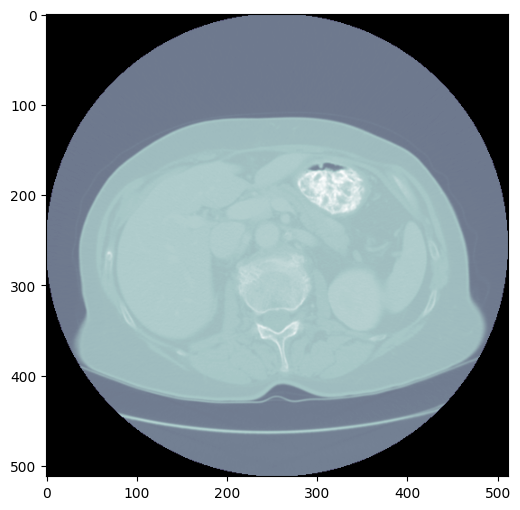

In [ ]:
# Image before windowing
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)), cmap=plt.cm.bone)

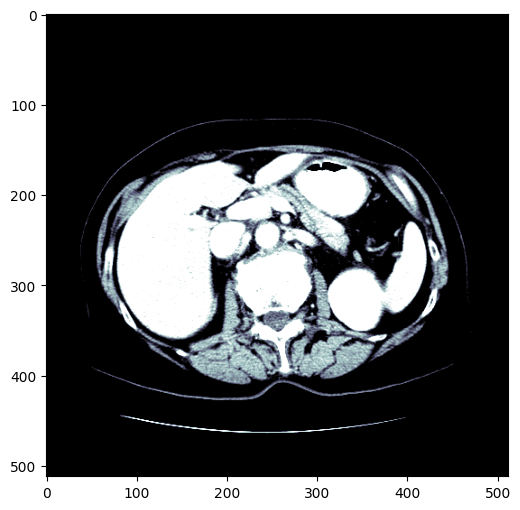

In [ ]:
# Image after windowing
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone)

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

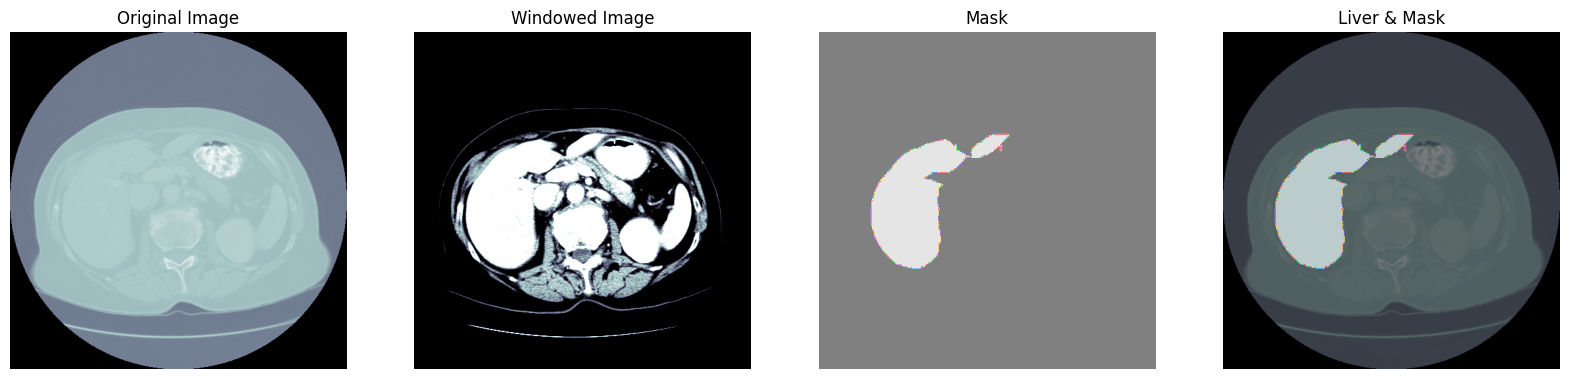

In [ ]:
sample = 55
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

# Plot a sample image and its mask
plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

<Axes: >

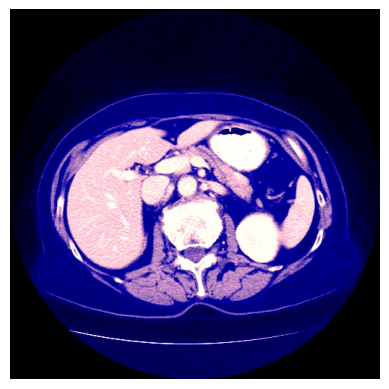

In [ ]:
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:Tensor, path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)


# Demonstration of image processing during conversion to jpg
_,axs = plt.subplots(1,1)
sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs, figsize=(8, 6))

In [ ]:
# Generating custom JPG files for segmentation model training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES):
    
    path = Path(".")

    Path('images').mkdir(exist_ok=True)
    Path('masks').mkdir(exist_ok=True)

    for ii in tqdm(range(0,len(df_files))):
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim):
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"masks/{curr_file_name}_slice_{curr_slice}_mask.png")

100%|██████████| 131/131 [1:16:43<00:00, 35.14s/it]


In [ ]:
# Creating a zip archive with all generated images
!zip -r liver_images.zip images

Предаденият резултат е скъсен до последните 5000 реда.
  adding: images/volume-124_slice_210.jpg (deflated 0%)
  adding: images/volume-20_slice_249.jpg (deflated 0%)
  adding: images/volume-49_slice_116.jpg (deflated 0%)
  adding: images/volume-98_slice_326.jpg (deflated 0%)
  adding: images/volume-16_slice_207.jpg (deflated 1%)
  adding: images/volume-109_slice_259.jpg (deflated 1%)
  adding: images/volume-82_slice_475.jpg (deflated 1%)
  adding: images/volume-18_slice_501.jpg (deflated 1%)
  adding: images/volume-2_slice_457.jpg (deflated 0%)
  adding: images/volume-60_slice_200.jpg (deflated 0%)
  adding: images/volume-116_slice_679.jpg (deflated 0%)
  adding: images/volume-116_slice_655.jpg (deflated 0%)
  adding: images/volume-94_slice_882.jpg (deflated 0%)
  adding: images/volume-88_slice_77.jpg (deflated 1%)
  adding: images/volume-52_slice_108.jpg (deflated 1%)
  adding: images/volume-97_slice_5.jpg (deflated 0%)
  adding: images/volume-49_slice_30.jpg (deflated 1%)
  adding: i

In [ ]:
# Checking the file size
!du -sh *

1.7G	drive
14G	images
14G	liver_images.zip
4.0K	liver.zip
233M	masks
55M	sample_data
188K	test.jpg


In [ ]:
# Splitting the 14GB archive into 4GB files for easier access
!zip liver_images.zip --out liver.zip -s 4g

Предаденият резултат е скъсен до последните 5000 реда.
 copying: images/volume-124_slice_210.jpg
 copying: images/volume-20_slice_249.jpg
 copying: images/volume-49_slice_116.jpg
 copying: images/volume-98_slice_326.jpg
 copying: images/volume-16_slice_207.jpg
 copying: images/volume-109_slice_259.jpg
 copying: images/volume-82_slice_475.jpg
 copying: images/volume-18_slice_501.jpg
 copying: images/volume-2_slice_457.jpg
 copying: images/volume-60_slice_200.jpg
 copying: images/volume-116_slice_679.jpg
 copying: images/volume-116_slice_655.jpg
 copying: images/volume-94_slice_882.jpg
 copying: images/volume-88_slice_77.jpg
 copying: images/volume-52_slice_108.jpg
 copying: images/volume-97_slice_5.jpg
 copying: images/volume-49_slice_30.jpg
 copying: images/volume-126_slice_17.jpg
 copying: images/volume-87_slice_93.jpg
 copying: images/volume-77_slice_56.jpg
 copying: images/volume-17_slice_750.jpg
 copying: images/volume-66_slice_16.jpg
 copying: images/volume-114_slice_522.jpg
 copy

In [ ]:
# Connecting the notebook with Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Copying the archives to Google Drive
!cp liver.zip /content/drive/MyDrive/
!cp liver.z01 /content/drive/MyDrive/
!cp liver.z02 /content/drive/MyDrive/
!cp liver.z03 /content/drive/MyDrive/